In [3]:
import numpy as np
import cv2
from PIL import Image
import sys
import matplotlib.pyplot as plt


def readPoints(path) :
    # Create an array of points.
    points = [];
    #Read points
    with open(path) as file :
        for line in file :
            x, y = line.split()
            points.append((int(x), int(y)))

    return points

#load the points  from the format we define in readme
def load_data(path):
    points = {}
    with open(path,'r') as reader:
        for line in reader:
            key,value = line.strip().split('=')
            x,y = value.split(',')
            x,y = int(x),int(y)
            points[key] = np.array([x,y])
    return points

#This python file is for morphing 
def affineTransform(src, srcTri, dstTri, size) :
    
    # Given a pair of triangles, find the affine transform.
    warpMat = cv2.getAffineTransform( np.float32(srcTri), np.float32(dstTri) )
     
    # Apply the Affine Transform just found to the src image
    dst = cv2.warpAffine( src, warpMat, (size[0], size[1]), None, flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT_101 )

    return dst
# Generate the triangles by using the opencv subdiv from the feature points
def DelaunaryTriangles(rect,points):
    subdiv = cv2.Subdiv2D(rect)
    Points_Dict = {}
    #Get the triangle list 
    for i,p in enumerate(points) :
        subdiv.insert((int(p[0]),int(p[1])))
        Points_Dict[(int(p[0]),int(p[1]))] = i 
    TriangleList = subdiv.getTriangleList();
    TriangleIndList = []
    #Get the index of the triangle points
    for t in TriangleList :
        t1 = (int(t[0]), int(t[1]))
        t2 = (int(t[2]), int(t[3]))
        t3 = (int(t[4]), int(t[5]))
        if t1 in Points_Dict and t2 in Points_Dict and t3 in Points_Dict:
            TriangleIndList.append([Points_Dict[t1],Points_Dict[t2],Points_Dict[t3]])
    return TriangleIndList

#Do deformation on oriImg
def morphing(Imgi,Imgj,Imgi_Points,Imgj_Points,alpha):
    Imgi_Points = add_margin_Points(Imgi_Points,Imgi)
    Imgj_Points = add_margin_Points(Imgj_Points,Imgj)
    newShape = Imgj.shape
    #Get the morph points on image M
    Imgm_Points = (1-alpha)*Imgi_Points + alpha*Imgj_Points
    #The delaunary triangles are based on the Img J
    TriangleIndList = DelaunaryTriangles((0,0,newShape[1],newShape[0]),Imgm_Points)
    Imgm = np.zeros(newShape,dtype=Imgj.dtype)
    for row in Imgm  :
        for term in row:
            term[3]=255
    imgs = [Imgi,Imgj,Imgm]
    #For each triangles, do the affine transformation
    for t in TriangleIndList:
    	tm = [[],[],[]]
    	for i in range(3):
        	tm[0].append(np.array(Imgi_Points[t[i]]))
        	tm[1].append(np.array(Imgj_Points[t[i]]))
        	tm[2].append(np.array(Imgm_Points[t[i]]))
        MorphingTriangle(imgs,tm,alpha)
    return imgs[2]

#Add 8 margin points on the borders
def add_margin_Points(Img_Points,img):
    total_points = []
    for point in Img_Points:
        total_points.append((int(point[0]),int(point[1])))
    y_size,x_size = img.shape[0]-1,img.shape[1]-1
    total_points.append((0,int(y_size)))
    total_points.append((int(x_size),int(y_size)))
    total_points.append((int(x_size),0))
    total_points.append((0,0))
    total_points.append((0,int(y_size/2)))
    total_points.append((int(x_size/2),0))
    total_points.append((int(x_size/2),int(y_size)))
    total_points.append((int(x_size),int(y_size/2)))
    return np.array(total_points)

#Morphing on the triangles 
def MorphingTriangle(imgs, tm, alpha):
    #Finding the corresponding rectangles and the images
    recs = []
    recImgs = []
    tRects = [[],[],[]]
    for i,t in enumerate(tm):
        #compute the rectangle boundary of each img
        recs.append(cv2.boundingRect(np.float32([t])))
        # get the corresponding rectangles on the imgs
        recImgs.append(imgs[i][recs[i][1]:(recs[i][1]+recs[i][3]),recs[i][0]:(recs[i][0]+recs[i][2])])
        # get the offsets corrdinates on the recImages
        for j in range(3):
            tRects[i].append(((tm[i][j][0]-recs[i][0]),(tm[i][j][1]-recs[i][1])))

    size = (recs[2][2],recs[2][3])
    #Apply the affineTransform function
    affineRec1 = affineTransform(recImgs[0],tRects[0],tRects[2],size)
    affineRec2 = affineTransform(recImgs[1],tRects[1],tRects[2],size)

    #Create the mask
    mask = np.zeros((recs[2][3], recs[2][2], imgs[2].shape[2]), dtype = np.float32)
    cv2.fillConvexPoly(mask,np.int32(tRects[2]),(1.0,1.0,1.0),16,0)

    #compute the morphing value
    morphRec = (1-alpha)*affineRec1 + alpha*affineRec2

    imgs[2][recs[2][1]:recs[2][1]+recs[2][3],recs[2][0]:recs[2][0]+recs[2][2]] = recImgs[2]*(1-mask)+mask*morphRec

#Invoke face++ api to detect the feature points
def facedetect(path):
    API_KEY = "RuF7pDgXRAl0EfZjZrWIYElt_QoO-XhN"
    API_SECRET = "lpUhYiPv8dSdFgMyjkaBKvO2X1nbKzv1"
    from facepp import API, File
    api = API(API_KEY, API_SECRET)
    result = api.detect(image_file=File(path),return_landmark=1)
    #we only detect face feature points
    landmarks = result['faces'][0]['landmark']
    feature_dict = {}
    for k,v in landmarks.iteritems():
        feature_dict[k] = np.array([v['x'],v['y']])
    return feature_dict

#The function is invoked by the run.py
def morphingAction(Imgi_path,Imgj_path,Imgi_point_path,Imgj_point_path,alpha):
    Imgi = np.array(Image.open(Imgi_path))
    Imgj = np.array(Image.open(Imgj_path))
    #the diffrent operation depend on whether the Image J contains a human face
    if Imgj_point_path != '':
        Imgj_Dict = load_data(Imgj_point_path)
        if Imagi_point_path != '':
            Imgi_Dict = load_data(Imgi_point_path)
        else:
            #Get the feature points of Image I
            Imgi_Dict = facedetect(Imgi_path)
    elif Imgi_point_path != '':
        Imgi_Dict = load_data(Imgi_point_path)
        Imgj_Dict = facedetect(Imgj_path)
        #get the union combination of keys
        Imgi_Keys=Imgi_Dict.keys()
        Imgj_Keys=Imgj_Dict.keys()
        Imgi_Imgj_Keys=list(set(Imgi_Keys).intersection(set(Imgj_Keys)))
        #change the keys to List
        Imgi_Points = []
        Imgj_Points = []
        for key in Imgi_Imgj_Keys:
            Imgi_Points.append(Imgi_Dict[key])
            Imgj_Points.append(Imgj_Dict[key])
        Imgi_Points = np.array(Imgi_Points)
        Imgj_Points = np.array(Imgj_Points)
    else:
        #if input two human face image i and j, then we just use face++ to detect the feature points
        Imgi_Dict=facedetect(Imgi_path)
        Imgj_Dict=facedetect(Imgj_path)
        Imgi_Points = []
        Imgj_Points = []
        for key in Imgi_Dict:
            Imgi_Points.append(Imgi_Dict[key])
            Imgj_Points.append(Imgj_Dict[key])
        Imgi_Points = np.array(Imgi_Points)
        Imgj_Points = np.array(Imgj_Points)

    ImgM = morphing(Imgi,Imgj,Imgi_Points,Imgj_Points,alpha)
    
    return ImgM



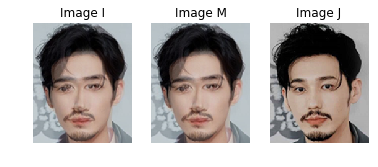

In [4]:
#Example 1:Morphed the images directly

Imgi = np.array(Image.open('C:/Users/acer/Desktop/img/zhuzhu_c.png'))
Imgj = np.array(Image.open('C:/Users/acer/Desktop/img/baibai_c.png'))
Imgm=Imgi
for i in range(Imgi.shape[0]):
    for j in range(Imgj.shape[1]):
        for m in range(4):
            Imgm[i,j][m]=0.5*Imgi[i,j][m]+0.5*Imgj[i,j][m]
            
plt.subplot(131)
plt.imshow(Imgi)
plt.title('Image I')
plt.axis('off')
plt.subplot(132)
plt.imshow(Imgm)
plt.title('Image M')
plt.axis('off')
plt.subplot(133)
plt.imshow(Imgj)
plt.title('Image J')
plt.axis('off')
plt.show()

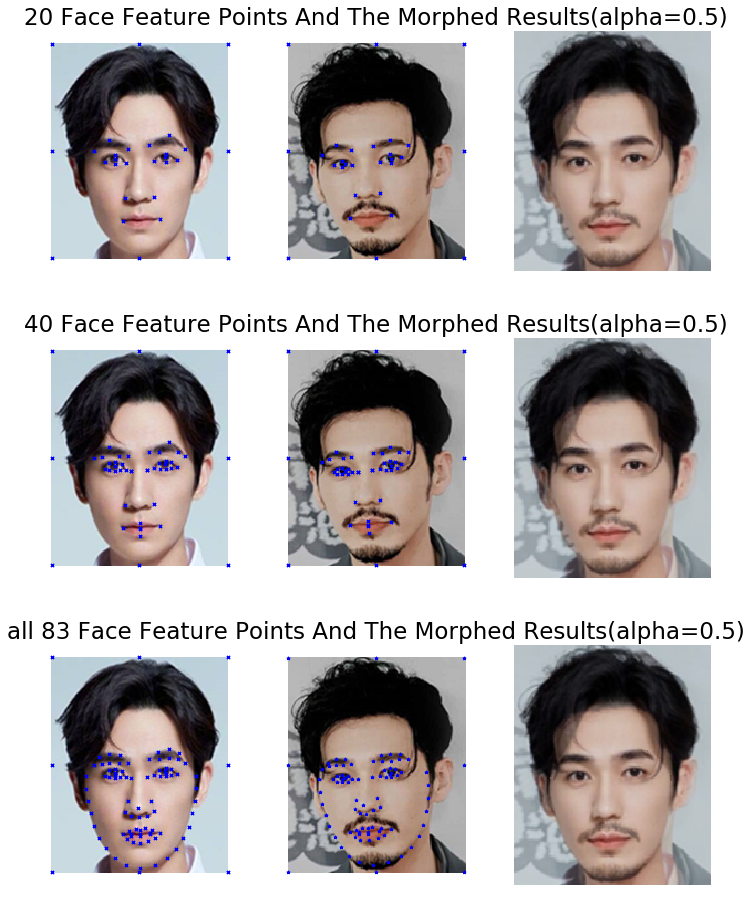

In [5]:
#Example 2:Add feature points

facePointi=facedetect('C:/Users/acer/Desktop/img/zhuzhu_c.png')
Imgi = np.array(Image.open('C:/Users/acer/Desktop/img/zhuzhu_c.png'))
facePointj=facedetect('C:/Users/acer/Desktop/img/baibai_c.png')
imgj = np.array(Image.open('C:/Users/acer/Desktop/img/baibai_c.png'))

#Only show the 8 margin points
def only_margin_points(img):
    points_ = []
    y_size,x_size = img.shape[0]-1,img.shape[1]-1
    points_.append((0,int(y_size)))
    points_.append((int(x_size),int(y_size)))
    points_.append((int(x_size),0))
    points_.append((0,0))
    points_.append((0,int(y_size/2)))
    points_.append((int(x_size/2),0))
    points_.append((int(x_size/2),int(y_size)))
    points_.append((int(x_size),int(y_size/2)))
    return np.array(points_)

#Show the 20 feature points and the morphed results
plt.figure(figsize=(12,16))
keys1=[u'right_eye_top',u'right_eye_bottom',u'right_eye_left_corner',u'right_eye_right_corner',u'right_eye_pupil',u'right_eyebrow_left_corner',
       u'right_eyebrow_right_corner',u'right_eyebrow_upper_middle', u'left_eye_top',u'left_eye_bottom',u'left_eye_left_corner',u'left_eye_right_corner',
       u'left_eye_pupil',u'left_eyebrow_left_corner',u'left_eyebrow_right_corner',u'left_eyebrow_upper_middle',u'nose_right',u'nose_left', u'mouth_left_corner',u'mouth_right_corner']
plt.subplot(331)
plt.imshow(Imgi)
for key in keys1:
    plt.scatter(facePointi[key][0],facePointi[key][1],s=10,color='b',marker='x')
ano_points=only_margin_points(Imgi)
for i in range(8):
    plt.scatter(ano_points[i][0],ano_points[i][1],s=10,color='b',marker='x')
plt.axis('off')

plt.subplot(332)
plt.imshow(Imgj)
for key in keys1:
    plt.scatter(facePointj[key][0],facePointj[key][1],s=10,color='b',marker='x')
ano_points=only_margin_points(Imgj)
for i in range(8):
    plt.scatter(ano_points[i][0],ano_points[i][1],s=10,color='b',marker='x')
plt.axis('off')
plt.title('20 Face Feature Points And The Morphed Results(alpha=0.5)',fontsize=23)

plt.subplot(333)
Imgi_Points=[]
Imgj_Points=[]
for i in keys1:
    Imgi_Points.append(facePointi[i])
    Imgj_Points.append(facePointj[i])
Imgi_Points = np.array(Imgi_Points)
Imgj_Points = np.array(Imgj_Points)
Imgm=morphing(Imgi,Imgj,Imgi_Points,Imgj_Points,0.5)
plt.axis('off')
plt.imshow(Imgm)

#Show the 40 feature points and the morphed results
keys2=[u'right_eye_top',u'right_eye_bottom',u'right_eye_left_corner',u'right_eye_right_corner',u'right_eye_pupil',u'right_eyebrow_left_corner',
       u'right_eyebrow_right_corner',u'right_eyebrow_upper_middle', u'left_eye_top',u'left_eye_bottom',u'left_eye_left_corner',u'left_eye_right_corner',     u'left_eye_pupil',u'left_eyebrow_left_corner',u'left_eyebrow_right_corner',u'left_eyebrow_upper_middle',u'nose_right',u'nose_left', u'mouth_left_corner',u'mouth_right_corner',
       u'right_eyebrow_lower_left_quarter',u'right_eyebrow_lower_right_quarter', u'left_eyebrow_lower_left_quarter',u'left_eyebrow_lower_right_quarter', u'left_eye_upper_left_quarter',
       u'left_eye_upper_right_quarter',u'left_eye_lower_left_quarter', u'left_eye_lower_right_quarter', u'right_eye_upper_left_quarter', u'right_eye_upper_right_quarter',
       u'right_eye_lower_left_quarter', u'right_eye_lower_right_quarter', u'nose_contour_left1', u'nose_contour_right1', u'nose_contour_left1', u'nose_contour_right1', 
       u'mouth_upper_lip_top', u'mouth_lower_lip_top', u'mouth_upper_lip_bottom', u'mouth_lower_lip_bottom']
plt.subplot(334)
plt.imshow(Imgi)
for key in keys2:
    plt.scatter(facePointi[key][0],facePointi[key][1],s=10,color='b',marker='x')
ano_points=only_margin_points(Imgi)
for i in range(8):
    plt.scatter(ano_points[i][0],ano_points[i][1],s=10,color='b',marker='x')
plt.axis('off')

plt.subplot(335)
plt.imshow(Imgj)
for key in keys2:
    plt.scatter(facePointj[key][0],facePointj[key][1],s=10,color='b',marker='x')
ano_points=only_margin_points(Imgj)
for i in range(8):
    plt.scatter(ano_points[i][0],ano_points[i][1],s=10,color='b',marker='x')
plt.axis('off')
plt.title('40 Face Feature Points And The Morphed Results(alpha=0.5)',fontsize=23)

plt.subplot(336)
Imgi_Points=[]
Imgj_Points=[]
for i in keys2:
    Imgi_Points.append(facePointi[i])
    Imgj_Points.append(facePointj[i])
Imgi_Points = np.array(Imgi_Points)
Imgj_Points = np.array(Imgj_Points)
Imgm=morphing(Imgi,Imgj,Imgi_Points,Imgj_Points,0.5)
plt.axis('off')
plt.imshow(Imgm)

#Show all the 83 feature points and the morphed results
plt.subplot(337)
plt.imshow(Imgi)
for key in facePointi.keys():
    plt.scatter(facePointi[key][0],facePointi[key][1],s=10,color='b',marker='x')
ano_points=only_margin_points(Imgi)
for i in range(8):
    plt.scatter(ano_points[i][0],ano_points[i][1],s=10,color='b',marker='x')
plt.axis('off')

plt.subplot(338)
plt.imshow(Imgj)
for key in facePointj.keys():
    plt.scatter(facePointj[key][0],facePointj[key][1],s=10,color='b',marker='*')
ano_points2=only_margin_points(Imgj)
for i in range(8):
    plt.scatter(ano_points2[i][0],ano_points2[i][1],s=10,color='b',marker='*')
plt.axis('off')
plt.title('all 83 Face Feature Points And The Morphed Results(alpha=0.5)',fontsize=23)

plt.subplot(339)
Imgi_Points = []
Imgj_Points = []  
for key in facePointj:
    Imgi_Points.append(facePointi[key])
    Imgj_Points.append(facePointj[key])
Imgi_Points = np.array(Imgi_Points)
Imgj_Points = np.array(Imgj_Points)
Imgm=morphing(Imgi,Imgj,Imgi_Points,Imgj_Points,0.5)
plt.axis('off')
plt.imshow(Imgm)

plt.show()

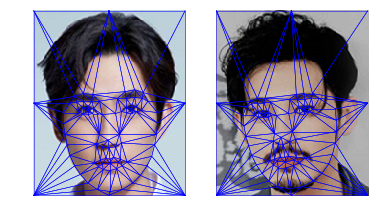

In [7]:
#Example 3:Delaunay Triangulation

Imgi_path = 'C:/Users/acer/Desktop/img/zhuzhu_c.png'
Imgj_path = 'C:/Users/acer/Desktop/img/baibai_c.png'

Imgi = np.array(Image.open(Imgi_path))
Imgj = np.array(Image.open(Imgj_path))

Imgi_Dict = facedetect(Imgi_path)
Imgj_Dict = facedetect(Imgj_path)

Imgi_Points = []
Imgj_Points = []

for key in Imgj_Dict:
    Imgi_Points.append(Imgi_Dict[key])
    Imgj_Points.append(Imgj_Dict[key])
Imgi_Points = np.array(Imgi_Points)
Imgj_Points = np.array(Imgj_Points)

Imgi_Points = add_margin_Points(Imgi_Points,Imgi)
Imgj_Points = add_margin_Points(Imgj_Points,Imgj)
newShape = Imgj.shape
#Get the morph points on image M
Imgm_Points = (1-0.5)*Imgi_Points + 0.5*Imgj_Points
#The delaunary triangles are based on the Img J
TriangleIndList = DelaunaryTriangles((0,0,newShape[1],newShape[0]),Imgm_Points)

plt.figure(figsize=(6,8))
plt.subplot(121)
plt.imshow(Imgi)
for i in range(len(TriangleIndList)):
    for j in range(3):
        plt.plot([Imgi_Points[TriangleIndList[i][j-1]][0],Imgi_Points[TriangleIndList[i][j]][0]],[Imgi_Points[TriangleIndList[i][j-1]][1],Imgi_Points[TriangleIndList[i][j]][1]],c='b',lineWidth=0.5)
plt.axis('off')

plt.subplot(122)
plt.imshow(Imgj)
for i in range(len(TriangleIndList)):
    for j in range(3):
        plt.plot([Imgj_Points[TriangleIndList[i][j-1]][0],Imgj_Points[TriangleIndList[i][j]][0]],[Imgj_Points[TriangleIndList[i][j-1]][1],Imgj_Points[TriangleIndList[i][j]][1]],c='b',lineWidth=0.5)
plt.axis('off')
plt.show()

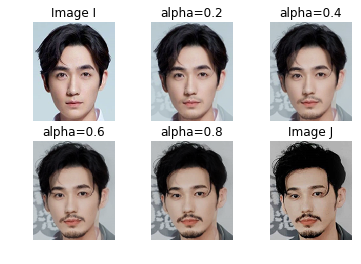

In [8]:
#Example 4:Different Alpha

Imgi_path = 'C:/Users/acer/Desktop/img/zhuzhu_c.png'
Imgj_path = 'C:/Users/acer/Desktop/img/baibai_c.png'
Imgi = np.array(Image.open(Imgi_path))
Imgj = np.array(Image.open(Imgj_path))  
Imgi_Dict = facedetect(Imgi_path)
Imgj_Dict = facedetect(Imgj_path)

Imgi_Points = []
Imgj_Points = []

for key in Imgj_Dict:
    Imgi_Points.append(Imgi_Dict[key])
    Imgj_Points.append(Imgj_Dict[key])
Imgi_Points = np.array(Imgi_Points)
Imgj_Points = np.array(Imgj_Points)
plt.subplot(231)
plt.imshow(Imgi)
plt.axis('off')
plt.title('Image I')
plt.subplot(232)
Imgm2 = morphing(Imgi,Imgj,Imgi_Points,Imgj_Points,0.2)
plt.imshow(Imgm2)
plt.axis('off')
plt.title('alpha=0.2')
plt.subplot(233)
Imgm4 = morphing(Imgi,Imgj,Imgi_Points,Imgj_Points,0.4)
plt.imshow(Imgm4)
plt.axis('off')
plt.title('alpha=0.4')
plt.subplot(234)
Imgm6 = morphing(Imgi,Imgj,Imgi_Points,Imgj_Points,0.6)
plt.imshow(Imgm6)
plt.axis('off')
plt.title('alpha=0.6')
plt.subplot(235)
Imgm8 = morphing(Imgi,Imgj,Imgi_Points,Imgj_Points,0.8)
plt.imshow(Imgm8)
plt.axis('off')
plt.title('alpha=0.8')
plt.subplot(236)
plt.imshow(Imgj)
plt.axis('off')
plt.title('Image J')
    
plt.show()

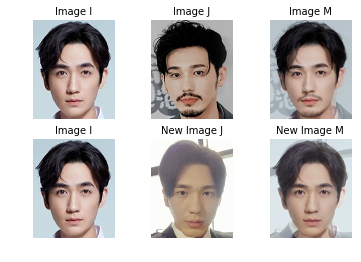

In [9]:
#Example 5:Different Initial Image

Imgi_path = 'C:/Users/acer/Desktop/img/zhuzhu_c.png'
Imgj_path = 'C:/Users/acer/Desktop/img/baibai_c.png'
Imgj2_path = 'C:/Users/acer/Desktop/img/change3.png'
Imgi = np.array(Image.open(Imgi_path))
Imgj = np.array(Image.open(Imgj_path))
Imgj2 = np.array(Image.open(Imgj2_path))
      
Imgi_Dict = facedetect(Imgi_path)
Imgj_Dict = facedetect(Imgj_path)
Imgj2_Dict = facedetect(Imgj2_path)

Imgi_Points = []
Imgj_Points = []
Imgj2_Points = []

for key in Imgj_Dict:
    Imgi_Points.append(Imgi_Dict[key])
    Imgj_Points.append(Imgj_Dict[key])
    Imgj2_Points.append(Imgj2_Dict[key])
Imgi_Points = np.array(Imgi_Points)
Imgj_Points = np.array(Imgj_Points)
Imgj2_Points = np.array(Imgj2_Points)

plt.subplot(231)
plt.imshow(Imgi)
plt.title('Image I',fontsize=10)
plt.axis('off')
plt.subplot(232)
plt.imshow(Imgj)
plt.title('Image J',fontsize=10)
plt.axis('off')
plt.subplot(233)
newimg=morphing(Imgi,Imgj,Imgi_Points,Imgj_Points,0.4)
plt.imshow(newimg)
plt.axis('off')
plt.title('Image M',fontsize=10)
plt.subplot(234)
plt.imshow(Imgi)
plt.axis('off')
plt.title('Image I',fontsize=10)
plt.subplot(235)
plt.imshow(Imgj2)
plt.axis('off')
plt.title('New Image J',fontsize=10)
plt.subplot(236)
newimg=morphing(Imgi,Imgj2,Imgi_Points,Imgj2_Points,0.4)
plt.imshow(newimg)
plt.axis('off')
plt.title('New Image M',fontsize=10)
    
plt.show()
    